In [44]:
# import all libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import kagglehub
import cv2
import mediapipe as mp


## 1. Data Collection

In [13]:
# setup kagglehub
kagglehub.login()
os.environ['KAGGLEHUB_CACHE'] = os.getcwd() + "/data/"


Kaggle credentials set.


In [ ]:
# Download Dataset
dataset_path = kagglehub.dataset_download("toxicmender/20bn-jester")
dataset_path

Resuming download from 6339690496 bytes (6472088266 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/toxicmender/20bn-jester?dataset_version_number=3 (6339690496/12811778762) bytes left.


100%|██████████| 11.9G/11.9G [1:37:38<00:00, 1.10MB/s] 

Extracting files...


In [45]:
dataset_path = os.path.join(os.getcwd(), "data", "datasets", "toxicmender", "20bn-jester", "versions", "3")
print(dataset_path)
print(os.listdir(dataset_path))

e:\DynamicHandRecognition\data\datasets\toxicmender\20bn-jester\versions\3
['Test', 'Test.csv', 'Train', 'Train.csv', 'Validation', 'Validation.csv']


## 2. Data Exploration

In [46]:
# load all 3 csv metadata files
train_df = pd.read_csv(os.path.join(dataset_path, "Train.csv"))
val_df = pd.read_csv(os.path.join(dataset_path, "Validation.csv"))
test_df = pd.read_csv(os.path.join(dataset_path, "Test.csv"))

In [47]:
# print stats of train_df
train_df.describe()

video_id   frames      label_id
count   50420.000000  50420.0  50420.000000
mean    73880.265212     37.0     12.175327
std     42797.621553      0.0      8.105991
min         1.000000     37.0      0.000000
25%     36681.750000     37.0      5.000000
50%     74140.500000     37.0     12.000000
75%    110992.500000     37.0     19.000000
max    148092.000000     37.0     26.000000

In [48]:
# print stats of val_df
val_df.describe()

video_id  frames     label_id
count    7047.000000  7047.0  7047.000000
mean    73746.899248    37.0    12.079183
std     42615.127783     0.0     8.226342
min        22.000000    37.0     0.000000
25%     36857.000000    37.0     5.000000
50%     74076.000000    37.0    12.000000
75%    110391.500000    37.0    19.000000
max    148071.000000    37.0    26.000000

In [49]:
# print stats of test_df
test_df.describe()

id  label  frames  label_id
count    6981.000000    0.0  6981.0       0.0
mean    74454.455809    NaN    37.0       NaN
std     42787.890293    NaN     0.0       NaN
min         2.000000    NaN    37.0       NaN
25%     37377.000000    NaN    37.0       NaN
50%     75131.000000    NaN    37.0       NaN
75%    111186.000000    NaN    37.0       NaN
max    148073.000000    NaN    37.0       NaN

In [50]:
# Extract unique labels from train_df
unique_labels = train_df['label'].unique()
N_CLASSES = len(unique_labels)
print(f"Number of hand gesture classes: {len(unique_labels)}")
print("Hand gesture classes:")
for i, label in enumerate(sorted(unique_labels)):
    print(f"{i}: {label}")

# Create a label mapping dictionary
label_to_id = {label: idx for idx, label in enumerate(sorted(unique_labels))}
id_to_label = {idx: label for label, idx in label_to_id.items()}

print(f"\nLabel mapping:")
for label_id, label in id_to_label.items():
    print(f"{label_id}: {label}")

Number of hand gesture classes: 27
Hand gesture classes:
0: Doing other things
1: Drumming Fingers
2: No gesture
3: Pulling Hand In
4: Pulling Two Fingers In
5: Pushing Hand Away
6: Pushing Two Fingers Away
7: Rolling Hand Backward
8: Rolling Hand Forward
9: Shaking Hand
10: Sliding Two Fingers Down
11: Sliding Two Fingers Left
12: Sliding Two Fingers Right
13: Sliding Two Fingers Up
14: Stop Sign
15: Swiping Down
16: Swiping Left
17: Swiping Right
18: Swiping Up
19: Thumb Down
20: Thumb Up
21: Turning Hand Clockwise
22: Turning Hand Counterclockwise
23: Zooming In With Full Hand
24: Zooming In With Two Fingers
25: Zooming Out With Full Hand
26: Zooming Out With Two Fingers

Label mapping:
0: Doing other things
1: Drumming Fingers
2: No gesture
3: Pulling Hand In
4: Pulling Two Fingers In
5: Pushing Hand Away
6: Pushing Two Fingers Away
7: Rolling Hand Backward
8: Rolling Hand Forward
9: Shaking Hand
10: Sliding Two Fingers Down
11: Sliding Two Fingers Left
12: Sliding Two Fingers Righ

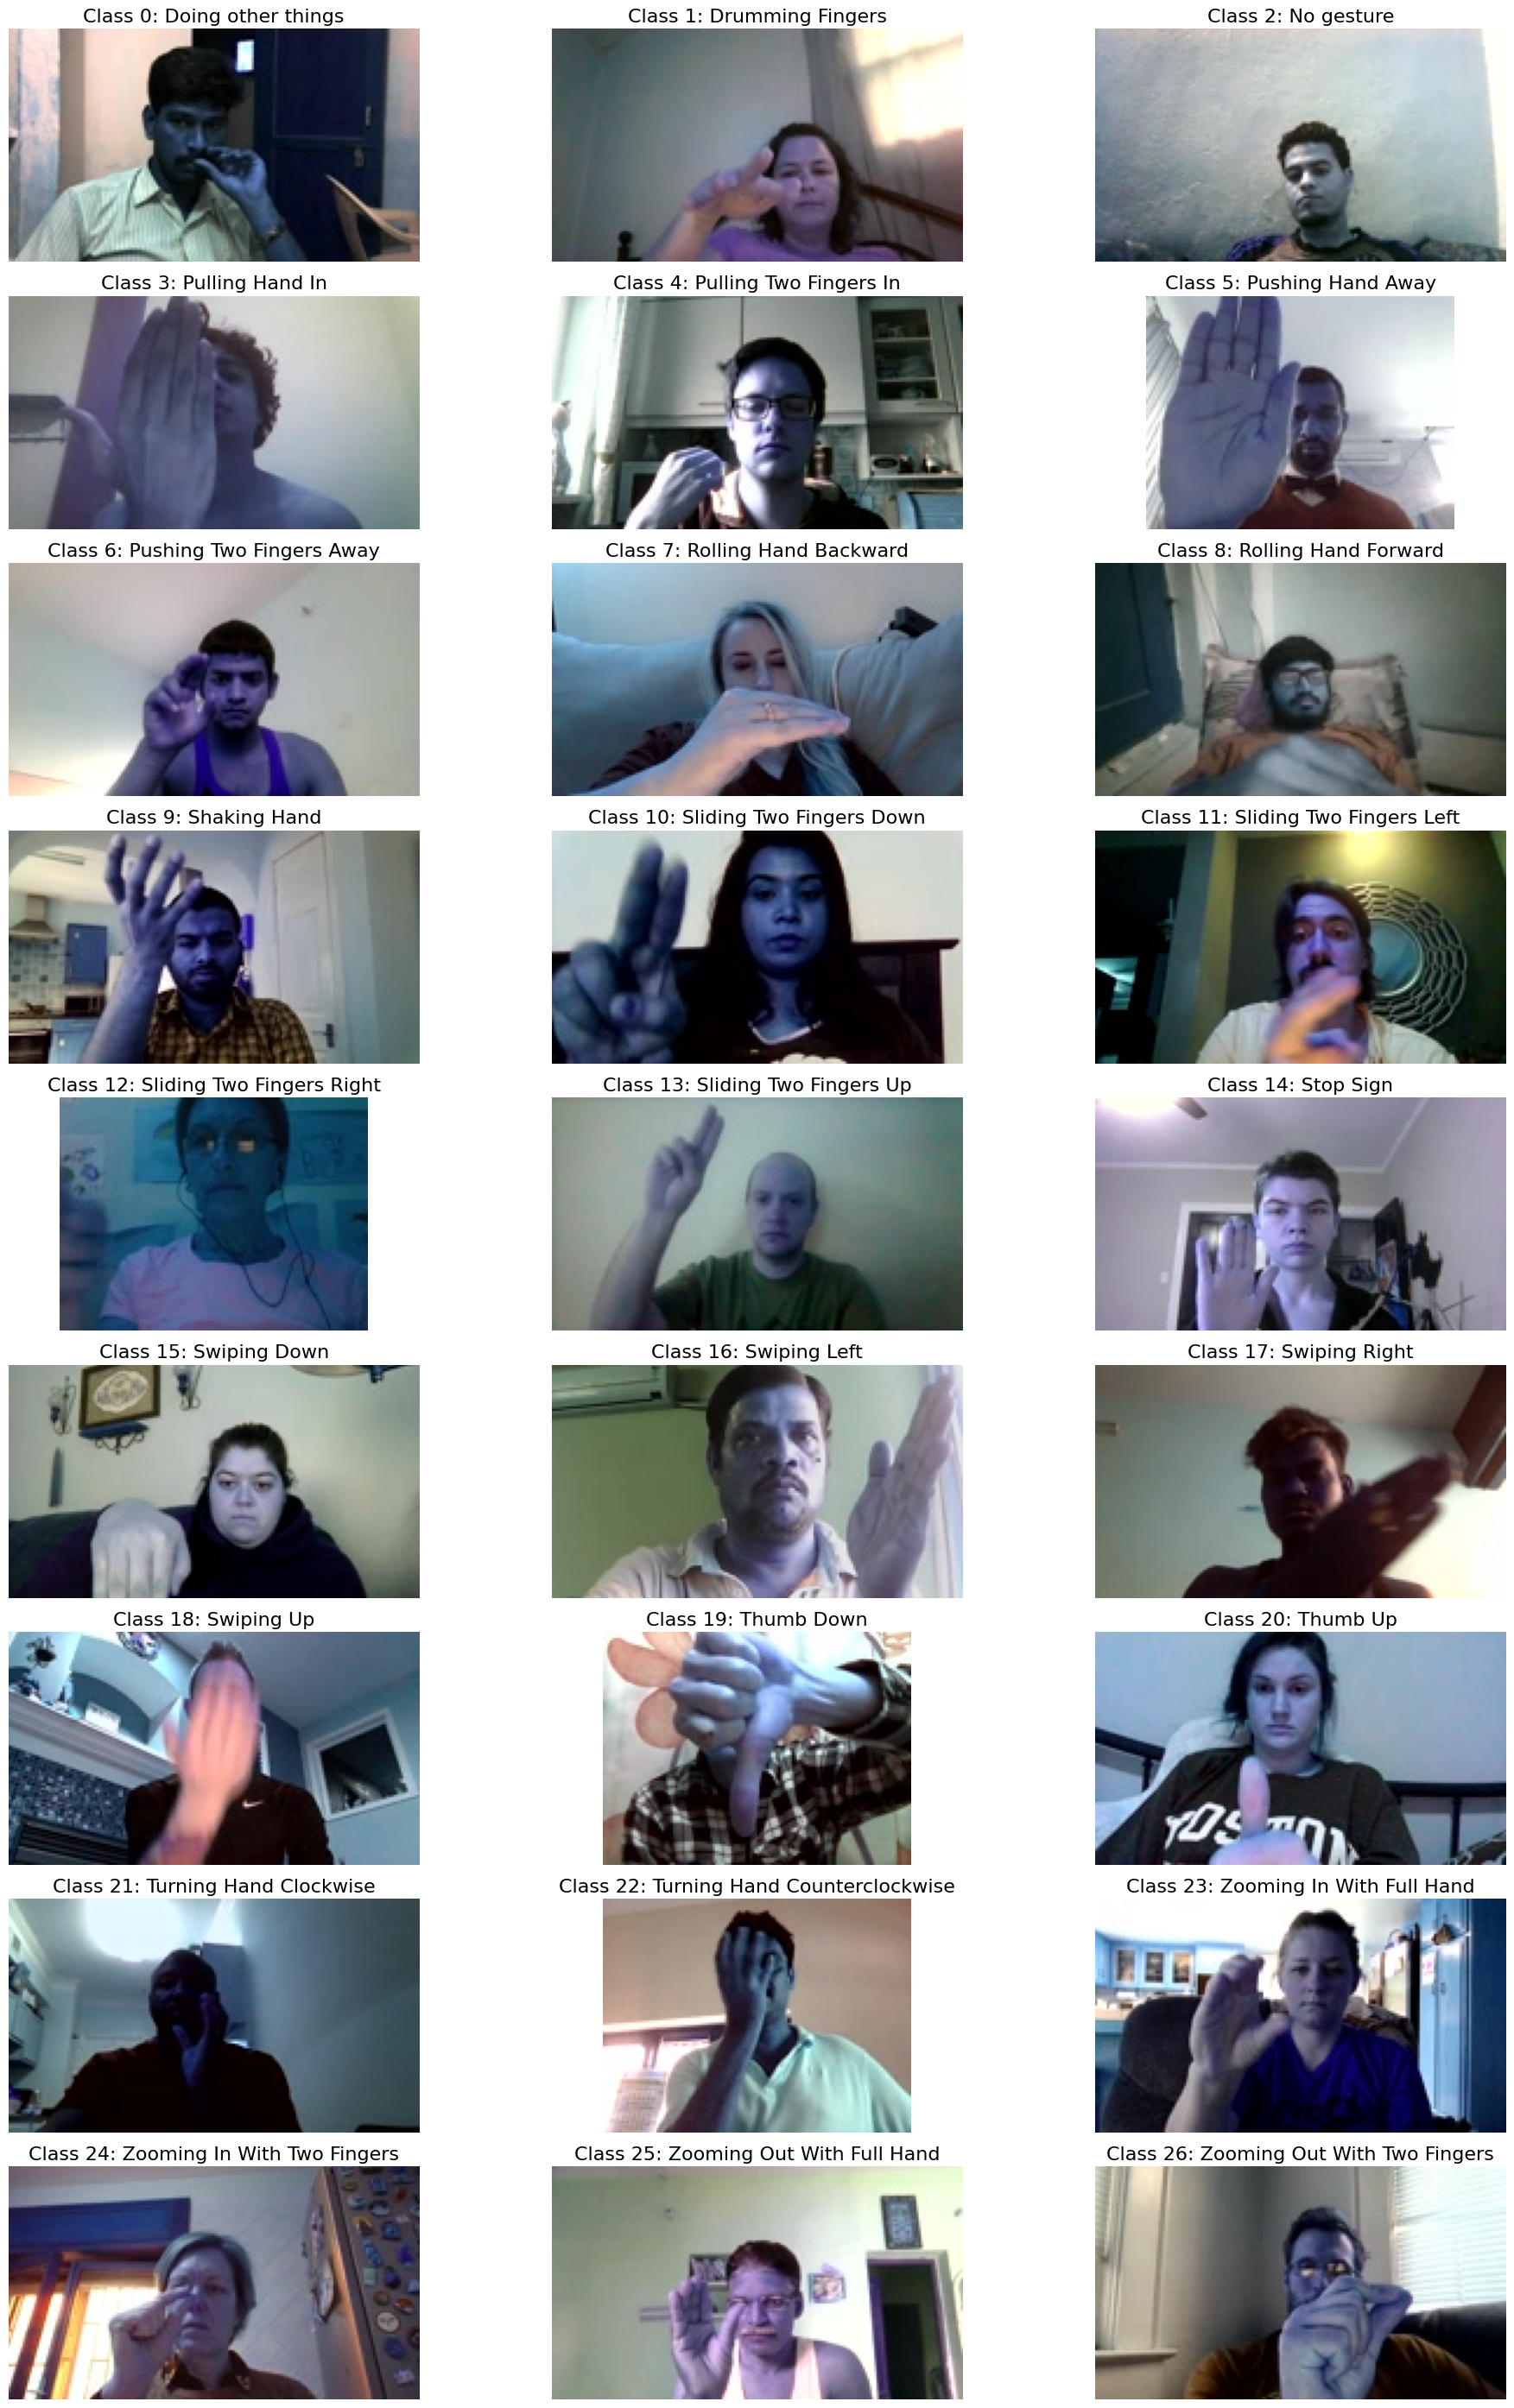

In [51]:
# show one frame(the middle one each has 37 frames so 18th frame) for each class
class_frames = []
# get the middle frame of each class take only one video from each class
for class_id in range(N_CLASSES):
    class_videos = train_df[train_df['label_id'] == class_id]
    class_videos = class_videos.sample(n=1)
    frame_path_dir = os.path.join(dataset_path, "Train", f"{class_videos['video_id'].iloc[0]}")
    # get the 8th frame file jpg
    frame_paths = [os.path.join(frame_path_dir, f) for f in os.listdir(frame_path_dir) if f.endswith('.jpg')]
    frame = cv2.imread(frame_paths[18], cv2.IMREAD_COLOR)
    class_frames.append(frame)

# plot the class frames in a grid # zoom in a little bit
fig, axes = plt.subplots(9,3, figsize=(20, 28))
axes = axes.flatten()
for i, frame in enumerate(class_frames):
    axes[i].imshow(frame)
    axes[i].set_title(f"Class {i}: {id_to_label[i]}", fontsize=16)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

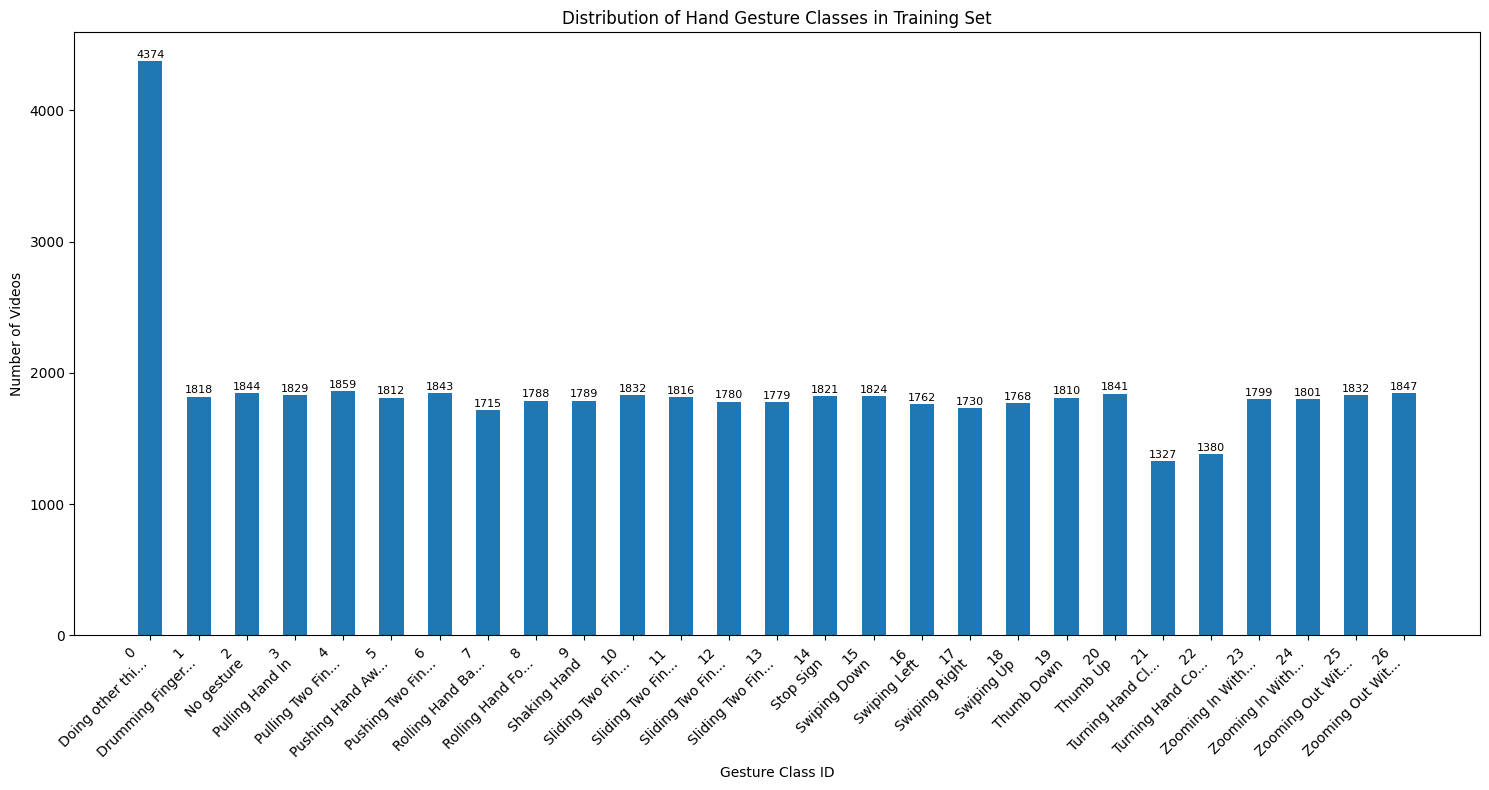

In [52]:
# Distribution of hand gesture classes in training set
plt.figure(figsize=(15, 8))
class_counts = train_df['label_id'].value_counts().sort_index()
bars = plt.bar(range(N_CLASSES), height=class_counts.values.astype(float), width=0.5)
plt.xlabel('Gesture Class ID')
plt.ylabel('Number of Videos')
plt.title('Distribution of Hand Gesture Classes in Training Set')
plt.xticks(range(N_CLASSES), [f"{i}\n{id_to_label[i][:15]}..." if len(id_to_label[i]) > 15 else f"{i}\n{id_to_label[i]}" for i in range(N_CLASSES)], rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


## 3. Propose Architecture for dynamic hand gesture recognition

1. Use Google's Mediapipe framework to capture hand gesture landmarks(21 x 3)

2. Then convert all frames to landmark 63x1 vector offline

3. Feed the converted numpy array 1D landmark feature vector to LSTM model to capture sequencial context feature from the video frames

4. Classify to 27 class labels

In [53]:
hand_landmarker_path = os.path.join(os.getcwd(), "models", "hand_landmarker.task")
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
HandLandmarkerResult = mp.tasks.vision.HandLandmarkerResult
VisionRunningMode = mp.tasks.vision.RunningMode

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=hand_landmarker_path),
    running_mode=VisionRunningMode.IMAGE)

# Drawing helpers
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_draw = mp.solutions.drawing_utils

In [54]:
# Visualize the mediapip hand landmark detection on sample video frames

# use cv2 to read the image
sample_image_path_dir = os.path.join(dataset_path, "Train", "14")

# get one of the jpg file in the directory jpegs  STOP SIGN
frame_path = [os.path.join(sample_image_path_dir, f) for f in os.listdir(sample_image_path_dir) if f.endswith('.jpg')][17]

sample_image = cv2.imread(frame_path, cv2.IMREAD_COLOR)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# # STEP 3: Load the input image.
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=sample_image)

# Create an HandLandmarker object.
detector = HandLandmarker.create_from_options(options)

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(mp_image)
# STEP 5: Process the classification result. In this case, visualize it.
if detection_result.hand_landmarks:
    for hand_landmarks in detection_result.hand_landmarks:
        print(hand_landmarks)
        for landmark in hand_landmarks:
            print(landmark)
            mp_draw.draw_landmarks(
                image=sample_image,
                landmark_list=hand_landmarks,
                connections=mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_draw.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                connection_drawing_spec=mp_draw.DrawingSpec(color=(255, 0, 0), thickness=2)
            )

cv2.imshow("annotated_image", sample_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

RuntimeError: Unable to open file at e:\DynamicHandRecognition\.venv\Lib\site-packages/e:\DynamicHandRecognition\models\hand_landmarker.task, errno=22